In [1]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

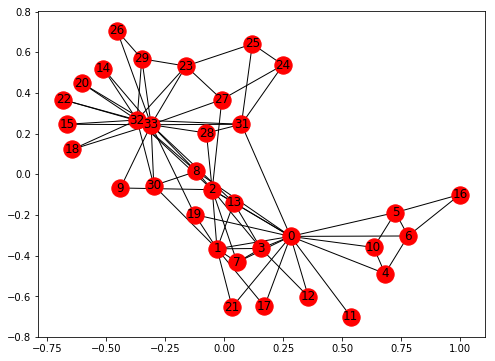

In [3]:
g = nx.karate_club_graph()
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(g, ax=ax)

In [4]:
nodes = [{'name': str(i), 'club': g.node[i]['club']}
         for i in g.nodes()]
links = [{'source': u[0], 'target': u[1]}
         for u in g.edges()]
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)

In [11]:
%%html
<div id="chart"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [12]:
%%javascript
// Dimensions of sunburst.
var width = 800;
var height = 300;

// Breadcrumb dimensions: width, height, spacing, width of tip/tail.
var b = {
  w: 75, h: 30, s: 3, t: 10
};

// Mapping of step names to colors.
var colors = {
  "home": "#5687d1",
  "product": "#7b615c",
  "search": "#de783b",
  "account": "#6ab975",
  "other": "#a173d1",
  "end": "#bbbbbb"
};

// Total size of all segments; we set this later, after loading the data.
var totalSize = 0; 

var vis = d3.select("#chart").append("svg:svg")
    .attr("width", width)
    .attr("height", height)
    .append("svg:g")
    .attr("id", "container");

var partition = d3.layout.partition()
    .size([width, height])
    .value(function(d) { return d.size; });

// Use d3.text and d3.csv.parseRows so that we do not need to have a header
// row, and can receive the csv as an array of arrays.
d3.text("visit-sequences.csv", function(text) {
  var csv = d3.csv.parseRows(text);
  var json = buildHierarchy(csv);
  createVisualization(json);
});

// Main function to draw and set up the visualization, once we have the data.
function createVisualization(json) {

  // Basic setup of page elements.
  initializeBreadcrumbTrail();
  drawLegend();
  d3.select("#togglelegend").on("click", toggleLegend);

  // Bounding rect underneath the chart, to make it easier to detect
  // when the mouse leaves the parent g.
  vis.append("svg:rect")
      .attr("width", width)
      .attr("height", height)
      .style("opacity", 0);

  // For efficiency, filter nodes to keep only those large enough to see.
  var nodes = partition.nodes(json)
      .filter(function(d) {
      return (d.dx > 0.5);
      });

  var node = vis.data([json]).selectAll(".node")
      .data(nodes)
      .enter().append("rect")
      .attr("class", "node")
      .attr("x", function(d) { return d.x; })
      .attr("y", function(d) { return d.y; })
      .attr("width", function(d) { return d.dx; })
      .attr("height", function(d) { return d.dy; })
      .attr("display", function(d) { return d.depth ? null : "none"; })
      .style("fill", function(d) { return colors[d.name]; })
      .style("opacity", 1)
      .on("mouseover", mouseover);

  // Add the mouseleave handler to the bounding rect.
  d3.select("#container").on("mouseleave", mouseleave);

  // Get total size of the tree = value of root node from partition.
  totalSize = node.node().__data__.value;
 };

// Fade all but the current sequence, and show it in the breadcrumb trail.
function mouseover(d) {

  var percentage = (100 * d.value / totalSize).toPrecision(3);
  var percentageString = percentage + "%";
  if (percentage < 0.1) {
    percentageString = "< 0.1%";
  }

  var sequenceArray = getAncestors(d);
  updateBreadcrumbs(sequenceArray, percentageString);

  // Fade all the segments.
  d3.selectAll(".node")
      .style("opacity", 0.3);

  // Then highlight only those that are an ancestor of the current segment.
  vis.selectAll(".node")
      .filter(function(node) {
                return (sequenceArray.indexOf(node) >= 0);
              })
      .style("opacity", 1);
}

// Restore everything to full opacity when moving off the visualization.
function mouseleave(d) {

  // Hide the breadcrumb trail
  d3.select("#trail")
      .style("visibility", "hidden");

  // Deactivate all segments during transition.
  d3.selectAll(".node").on("mouseover", null);

  // Transition each segment to full opacity and then reactivate it.
  d3.selectAll(".node")
      .transition()
      .duration(1000)
      .style("opacity", 1)
      .each("end", function() {
              d3.select(this).on("mouseover", mouseover);
            });
}

// Given a node in a partition layout, return an array of all of its ancestor
// nodes, highest first, but excluding the root.
function getAncestors(node) {
  var path = [];
  var current = node;
  while (current.parent) {
    path.unshift(current);
    current = current.parent;
  }
  return path;
}

function initializeBreadcrumbTrail() {
  // Add the svg area.
  var trail = d3.select("#sequence").append("svg:svg")
      .attr("width", width)
      .attr("height", 50)
      .attr("id", "trail");
  // Add the label at the end, for the percentage.
  trail.append("svg:text")
    .attr("id", "endlabel")
    .style("fill", "#000");
}

// Generate a string that describes the points of a breadcrumb polygon.
function breadcrumbPoints(d, i) {
  var points = [];
  points.push("0,0");
  points.push(b.w + ",0");
  points.push(b.w + b.t + "," + (b.h / 2));
  points.push(b.w + "," + b.h);
  points.push("0," + b.h);
  if (i > 0) { // Leftmost breadcrumb; don't include 6th vertex.
    points.push(b.t + "," + (b.h / 2));
  }
  return points.join(" ");
}

// Update the breadcrumb trail to show the current sequence and percentage.
function updateBreadcrumbs(nodeArray, percentageString) {

  // Data join; key function combines name and depth (= position in sequence).
  var g = d3.select("#trail")
      .selectAll("g")
      .data(nodeArray, function(d) { return d.name + d.depth; });

  // Add breadcrumb and label for entering nodes.
  var entering = g.enter().append("svg:g");

  entering.append("svg:polygon")
      .attr("points", breadcrumbPoints)
      .style("fill", function(d) { return colors[d.name]; });

  entering.append("svg:text")
      .attr("x", (b.w + b.t) / 2)
      .attr("y", b.h / 2)
      .attr("dy", "0.35em")
      .attr("text-anchor", "middle")
      .text(function(d) { return d.name; });

  // Set position for entering and updating nodes.
  g.attr("transform", function(d, i) {
    return "translate(" + i * (b.w + b.s) + ", 0)";
  });

  // Remove exiting nodes.
  g.exit().remove();

  // Now move and update the percentage at the end.
  d3.select("#trail").select("#endlabel")
      .attr("x", (nodeArray.length + 0.5) * (b.w + b.s))
      .attr("y", b.h / 2)
      .attr("dy", "0.35em")
      .attr("text-anchor", "middle")
      .text(percentageString);

  // Make the breadcrumb trail visible, if it's hidden.
  d3.select("#trail")
      .style("visibility", "");

}

function drawLegend() {

  // Dimensions of legend item: width, height, spacing, radius of rounded rect.
  var li = {
    w: 75, h: 30, s: 3, r: 3
  };

  var legend = d3.select("#legend").append("svg:svg")
      .attr("width", li.w)
      .attr("height", d3.keys(colors).length * (li.h + li.s));

  var g = legend.selectAll("g")
      .data(d3.entries(colors))
      .enter().append("svg:g")
      .attr("transform", function(d, i) {
              return "translate(0," + i * (li.h + li.s) + ")";
           });

  g.append("svg:rect")
      .attr("rx", li.r)
      .attr("ry", li.r)
      .attr("width", li.w)
      .attr("height", li.h)
      .style("fill", function(d) { return d.value; });

  g.append("svg:text")
      .attr("x", li.w / 2)
      .attr("y", li.h / 2)
      .attr("dy", "0.35em")
      .attr("text-anchor", "middle")
      .text(function(d) { return d.key; });
}

function toggleLegend() {
  var legend = d3.select("#legend");
  if (legend.style("visibility") == "hidden") {
    legend.style("visibility", "");
  } else {
    legend.style("visibility", "hidden");
  }
}

// Take a 2-column CSV and transform it into a hierarchical structure suitable
// for a partition layout. The first column is a sequence of step names, from
// root to leaf, separated by hyphens. The second column is a count of how 
// often that sequence occurred.
function buildHierarchy(csv) {
  var root = {"name": "root", "children": []};
  for (var i = 0; i < csv.length; i++) {
    var sequence = csv[i][0];
    var size = +csv[i][1];
    if (isNaN(size)) { // e.g. if this is a header row
      continue;
    }
    var parts = sequence.split("-");
    var currentNode = root;
    for (var j = 0; j < parts.length; j++) {
      var children = currentNode["children"];
      var nodeName = parts[j];
      var childNode;
      if (j + 1 < parts.length) {
   // Not yet at the end of the sequence; move down the tree.
    var foundChild = false;
    for (var k = 0; k < children.length; k++) {
        if (children[k]["name"] == nodeName) {
            childNode = children[k];
            foundChild = true;
            break;
        }
    }
  // If we don't already have a child node for this branch, create it.
    if (!foundChild) {
        childNode = {"name": nodeName, "children": []};
        children.push(childNode);
    }
    currentNode = childNode;
    } else {
    // Reached the end of the sequence; create a leaf node.
    childNode = {"name": nodeName, "size": size};
    children.push(childNode);
      }
    }
  }
  return root;
};

<IPython.core.display.Javascript object>